# Clustering Tree Explainer


When executing a clustering algorithm like K-Means usually the samples in our dataset are partitioned to K different clusters/groups. However, sometimes is difficult to understand why a sample is assigned to a particular cluster or what are the features that characterize a cluster. To improve interpretability, a small decision tree can be used to partition the data in the assigned clusters of a previously run clustering algorithm. In this tutorial, we show how we can build this decision tree using the `ClusteringTreeExplainer` class. This class builds a decision tree based on the [Iterative Mistake Minimization (IMM)](https://arxiv.org/pdf/2002.12538.pdf) method and [ExKMC: Expanding Explainable k-Means Clustering] (https://arxiv.org/pdf/2006.02399.pdf)


In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Example 1 (Pandas DataFrame)

We show first an example of a simple dataset in 2 dimensions which has 3 well separated clusters. We will create a Pandas DataFrame in this case.

The example is based on the one found in https://github.com/navefr/ExKMC


Let's create the dataset:

In [2]:
n = 1000
d = 2
k = 3
x_data, _ = make_blobs(n_samples=n, n_features=d, centers=k, cluster_std=2.5, random_state=42)
df = pd.DataFrame(x_data, columns=["feature_1", "feature_2"])

<b> K-Means </b>

Now, let's execute our K-Means algorithm:

In [3]:
kmeans = KMeans(k, random_state=42)
kmeans.fit(df)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

We can plot how our fitted K-Means separates the clusters:

<ipython-input-4-0acd42ed5d6e>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('PuBuGn')
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


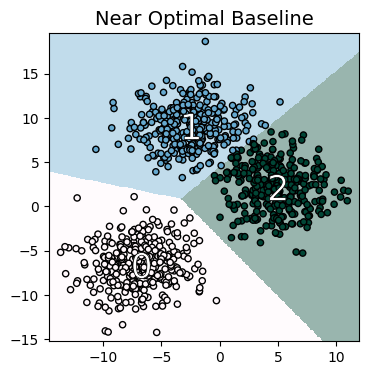

In [4]:
def plot_kmeans(kmeans, x_data):
    cmap = plt.cm.get_cmap('PuBuGn')

    k = kmeans.n_clusters
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    values = np.c_[xx.ravel(), yy.ravel()]

    plt.figure(figsize=(4, 4))
    Z = kmeans.predict(values)
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap,
               aspect='auto', origin='lower', alpha=0.4)

    y_kmeans = kmeans.predict(x_data)
    plt.scatter([x[0] for x in x_data], [x[1] for x in x_data], c=y_kmeans, s=20, edgecolors='black', cmap=cmap)
    for c in range(k):
        center = x_data[y_kmeans == c].mean(axis=0)
        plt.scatter([center[0]], [center[1]], c="white", marker='$%s$' % c, s=350, linewidths=.5, zorder=10,
                    edgecolors='black')

    plt.title("Near Optimal Baseline", fontsize=14)
    plt.show()
    
plot_kmeans(kmeans, df.values)

<b> Clustering Tree Explainer </b>

Now, let's use the `ClusteringTreeExplainer` to try to find an explanation on how our k-means is partitioning the data. We first create an instance of the class and call the method `explain()` passing our pandas dataframe. This will return us an explanation object. Then, by calling `plot()` we will obtain the Decision Tree, which we can visualize. Note that we need to have installed  the graphviz library

In [5]:
from mercury.explainability.explainers import ClusteringTreeExplainer

clustering_tree_explainer = ClusteringTreeExplainer(clustering_model=kmeans, max_leaves=k)
explanation = clustering_tree_explainer.explain(df)
plot_explanation = explanation.plot(filename="clustering_tree_explanation")

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


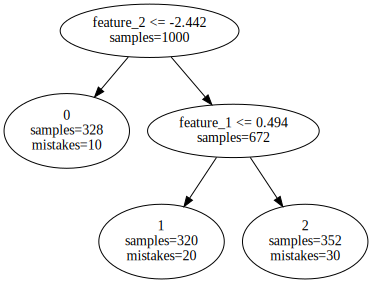

In [6]:
plot_explanation

As we are using only 2 dimensions, we can also visualize how the decision tree is partitioning the dataset:

<ipython-input-7-748a68ab0f69>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('PuBuGn')
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
<ipython-input-7-748a68ab0f69>:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)
<ipython-input-7-748a68ab0f69>:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], mar

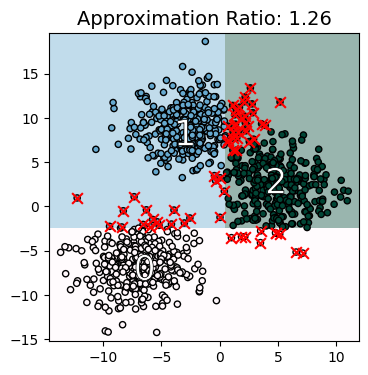

In [7]:
def plot_tree_boundary(cluster_tree, k, x_data, kmeans, plot_mistakes=False):
    cmap = plt.cm.get_cmap('PuBuGn')
    
    plt.figure(figsize=(4, 4))
    
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    values = np.c_[xx.ravel(), yy.ravel()]
    
    y_cluster_tree = cluster_tree.tree.predict(x_data)

    Z = cluster_tree.tree.predict(values)
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap, 
               aspect='auto', origin='lower', alpha=0.4)


    plt.scatter([x[0] for x in x_data], [x[1] for x in x_data], c=y_cluster_tree, edgecolors='black', s=20, cmap=cmap)
    for c in range(k):
        center = x_data[y_cluster_tree==c].mean(axis=0)
        plt.scatter([center[0]], [center[1]], c="white", marker='$%s$' % c, s=350, linewidths=.5, zorder=10, edgecolors='black')
        
    if plot_mistakes:
        y = kmeans.predict(x_data)
        mistakes = x_data[y_cluster_tree != y]
        plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)

    plt.title("Approximation Ratio: %.2f" % (cluster_tree.score(x_data) / -kmeans.score(x_data)), fontsize=14)
    plt.show()

plot_tree_boundary(clustering_tree_explainer, k, x_data, kmeans, plot_mistakes=True)

We can also save our tree by calling `render()` method:

In [8]:
plot_explanation.render()

'clustering_tree_explanation.gv.png'

## Example 2: Wine Quality Dataset (Spark)

Now, we will use the Wine Quality dataset to create clusters of wines. We will also use a Spark DataFrame instead of Pandas. Note that the dataset is small enough to fit in memory and we use Spark just for illustration purposes.

<b> We first load the dataset and do some preprocessing </b>

In [9]:
df_red_wines = pd.read_csv("./data/winequality/winequality-red.csv")
df_white_wines = pd.read_csv("./data/winequality/winequality-white.csv")

df_red_wines["type"] = "red"
df_white_wines["type"] = "white"

df = pd.concat([df_red_wines, df_white_wines])

In [10]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [11]:
num_feats = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol', 
]
cat_feats = [
    'type'
]

df = df[num_feats + cat_feats]
df = pd.get_dummies(df, columns=cat_feats)

In [12]:
from sklearn.preprocessing import StandardScaler

scalers = {}
for c in df.columns:
    scalers[c] = StandardScaler()
    df[c] = scalers[c].fit_transform(df[c].values.reshape(-1, 1))

In [13]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,1.75019,-1.75019
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,1.75019,-1.75019
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,1.75019,-1.75019
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,1.75019,-1.75019
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,1.75019,-1.75019


<b> Create Spark K-Means Pipeline </b>

In [14]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Mercury Example").getOrCreate()
spark_df = spark.createDataFrame(df)

In [15]:
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

k = 4

assembler = VectorAssembler(inputCols=spark_df.columns, outputCol="features")
spark_kmeans = SparkKMeans(k=k, seed=10)
spark_pipeline = Pipeline(stages=[assembler, spark_kmeans])
spark_pipeline_model = spark_pipeline.fit(spark_df)

<b> Clustering Tree Explainer </b>

Let's create a `ClusetringTreeExplainer` as before. As we normalized the data before and we haven't include the normalization step in our pipeline, our explanation would show the normalized values which are less interpretable than the actual values. In order to avoid that, we can pass the scalers that we used to the `scalers` parameter when plotting our explanation. In this way, the original values are shown in the tree splits.

Note: If your dataset doesn't fit in memory, you can use the `subsample` argument in the `explain` method. By setting this argument to 0.5 for example, 50% of the Spark DataFrame will be subsampled when fitting the tree.

In [16]:
%%time

from mercury.explainability.explainers import ClusteringTreeExplainer

clustering_tree_explainer = ClusteringTreeExplainer(clustering_model=spark_pipeline_model, max_leaves=k)
explanation = clustering_tree_explainer.explain(spark_df)
plot_explanation = explanation.plot(filename="wine_clustering_explanation_tree", scalers=scalers)

CPU times: user 249 ms, sys: 13 ms, total: 262 ms
Wall time: 1.54 s


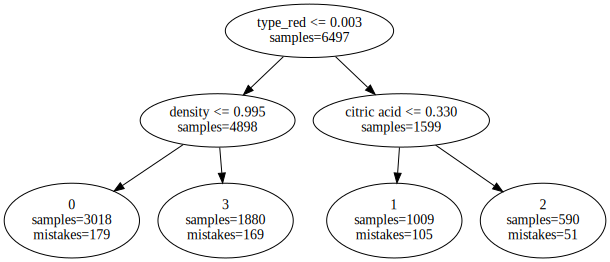

In [17]:
plot_explanation

Therefore, we can summarize our clusters in the next way:
- One cluster contains white wines with density lower than 0.995
- A second cluster contains white wines with density higher than 0.995
- A third cluster contains red wines with citric acid lower than 0.33
- A fourth contains red wines with citric acid higher than 0.33

### Further functionalities:

The `ClusteringTreeExplainer` contains additional functionality. We highlight some of it:
- Specify a higher number of leaves than clusters. This is following the ExKMC method explained in this paper: [ExKMC: Expanding Explainable k-Means Clustering](https://docs.google.com/document/d/1KLvyS_102GIGHNeaV3tWh6hTnEdC1Stwj5N5GAEPhO0/edit#heading=h.8v13nlfbm1h6). In this way, you can achieve better partitioning.
- Let the `ClusteringTreeExplainer` run the clustering model itself. If you don't specify a fitted clustering model, the `ClusteringTreeExplainer` will run a K-Means with the default parameters.
- Perform subsampling when using a Spark Dataframe. If your dataframe is too big to fit in memory, you can try to use the subsample argument to subsample your dataset when fitting the decision tree.
- When performing the clustering algorithm, you can include de normalization as a step in a sklearn pipeline or pyspark pipeline. In this way, you don't need to pass the scalers when plotting the explanation as in the last example

You can check the class documentation for additional information